# Let's try if we can use our model trained without fragment information to be constrained to fragment.

In [22]:
from gpt3forchem.api_wrappers import fine_tune, query_gpt3, extract_prediction
import EFGs

from gpt3forchem.data import get_bandgap_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from gpt3forchem.output import test_inverse_bandgap

from rdkit.Contrib.SA_Score.sascorer import calculateScore as calculate_sascore
from rdkit.Chem import Draw
from rdkit import Chem

from scipy import stats
plt.style.use(['science', 'nature'])

In [6]:
data= get_bandgap_data()

In [3]:
def draw_smiles(smiles, maxmol=10, molsPerRow=4, subImgSize=(300, 300)):
    mols = []
    sascores = []
    for s in smiles:
        if len(s) > 5:
            try: 
                mol = Chem.MolFromSmiles(s)
                mols.append(mol)
                sascores.append(str(np.round(calculate_sascore(mol),2)))
            except:
                pass

    img=Draw.MolsToGridImage(mols[:maxmol], molsPerRow=molsPerRow,subImgSize=subImgSize, useSVG=True, legends=sascores[:maxmol])  
    return img

In [14]:
def test_inverse_model(
    modelname,
    test_prompts,
    df_train,
    max_tokens: int = 250,
    temperatures=None,
    representation="SMILES",
 #   fragment='C(=O)',
):
    temperatures = temperatures or [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
    train_smiles = df_train["SMILES"].to_list()
    results = []
    for temperature in temperatures:
        try:
            print(f"Testing temperature {temperature} for {representation}")
            result = test_inverse_bandgap(
                test_prompts,
                modelname,
                train_smiles=train_smiles,
                temperature=temperature,
                max_tokens=max_tokens,
                representation=representation,
            )
            
            # fragment_in_smiles = [fragment in s for s in result['smiles']]
            # result['fragment_in_smiles'] = len(fragment_in_smiles)/sum(result['smiles'])
            results.append(result)
        except Exception as e:
            print(e)
            pass

    return results

In [9]:
test_data = data.sample(100)
test_data['fragment'] = "C(=O)C1=CC=C(C=C1)"

In [13]:
PROMPT_TEMPLATE_bandgap_inverse = "What is a molecule with a bandgap of {} eV and {} as part of the molecule###"
COMPLETION_TEMPLATE_bandgap_inverse = "{}@@@"


def generate_inverse_photoswitch_prompts_with_fragment(
    data: pd.DataFrame,  representation: str = "smiles"
) -> pd.DataFrame:
    prompts = []
    completions = []
    smiles = []
    for i, row in data.iterrows():

        prompt = PROMPT_TEMPLATE_bandgap_inverse.format(
            np.round(row["GFN2_HOMO_LUMO_GAP"] * 27.2114, 1), row['fragment']
        )

        completion = COMPLETION_TEMPLATE_bandgap_inverse.format(row[representation])
        prompts.append(prompt)
        completions.append(completion)
        smiles.append(row["smiles"])

    prompts = pd.DataFrame(
        {"prompt": prompts, "completion": completions, "SMILES": smiles}
    )

    return prompts

In [10]:
test_prompt = generate_inverse_photoswitch_prompts_with_fragment(test_data)

In [15]:
train_prompts_very_very_large_smiles = pd.read_csv('run_files/2022-11-27-22-29-43500000_smiles_train.csv')

In [16]:
res_50000_smiles = test_inverse_model(
    "ada:ft-lsmoepfl-2022-11-28-16-40-07",
    test_prompt,
    train_prompts_very_very_large_smiles,
    representation="SMILES",
)

Testing temperature 0 for SMILES


2022-12-02 09:52:43.501 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: C(C([H])([H])[H])(C([H])([H])[H])C2=C(C([H])([H])[H])C(=O)C(C2=O)C1=C(C([H])([H])[H])C2(C([H])([H])[H])C([H])([H])[H]
2022-12-02 09:52:43.502 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: C(C([H])([H])[H])(C([H])([H])[H])C2=C(C([H])([H])[H])C(=O)C(C2=O)C1=C(C([H])([H])[H])C2(C([H])([H])[H])C([H])([H])[H]
2022-12-02 09:52:43.524 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 0 samples
2022-12-02 09:52:43.524 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: nan


Testing temperature 0.25 for SMILES


2022-12-02 09:53:18.309 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: C(C([H])([H])[H])(C([H])([H])[H])C2=C(C([H])([H])[H])C(=O)C(C2=O)C1=C(C([H])([H])[H])C2(C([H])([H])[H])C([H])([H])[H]
2022-12-02 09:53:18.309 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: C(C([H])([H])[H])(C([H])([H])[H])C2=C(C([H])([H])[H])C(=O)C(C2=O)C1=C(C([H])([H])[H])C2(C([H])([H])[H])C([H])([H])[H]
2022-12-02 09:53:18.340 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 4 samples
2022-12-02 09:53:18.466 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-02 09:53:19.288034: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-02 09:53:27.133 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (53

Testing temperature 0.5 for SMILES


2022-12-02 09:54:02.071 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: C(C([H])([H])[H])(C([H])([H])[H])C1=O)C2=C(C([H])([H])[H])C2=O)C1=C(C([H])([H])[H])C([H])([H])[H]
2022-12-02 09:54:02.071 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: C(C([H])([H])[H])(C([H])([H])[H])C1=O)C2=C(C([H])([H])[H])C2=O)C1=C(C([H])([H])[H])C([H])([H])[H]
2022-12-02 09:54:02.122 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 13 samples
2022-12-02 09:54:02.272 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-02 09:54:08.012 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (59.04644608188653, 7.435169234978529e-06)
2022-12-02 09:54:08.140 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.201534534778

Testing temperature 0.75 for SMILES


2022-12-02 09:54:43.074 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: C(C([H])([H])[H])(C([H])([H])[H])C1=O)C4=C1C2=C(C([H])([H])C(=O)C1=C(C([H])([H])C4([H])[H])C2([H])[H]
2022-12-02 09:54:43.076 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: C(C([H])([H])[H])(C([H])([H])[H])C1=O)C4=C1C2=C(C([H])([H])C(=O)C1=C(C([H])([H])C4([H])[H])C2([H])[H]
2022-12-02 09:54:43.116 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 7 samples
2022-12-02 09:54:43.262 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-02 09:54:48.166 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (59.13248023854458, 7.308327930030318e-06)
2022-12-02 09:54:48.282 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: nan


Testing temperature 1.0 for SMILES


2022-12-02 09:55:24.568 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: QS
2022-12-02 09:55:24.569 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: QS
2022-12-02 09:55:24.596 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 8 samples
2022-12-02 09:55:24.684 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-02 09:55:32.046 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (57.689490864660876, 9.753365305868008e-06)
2022-12-02 09:55:32.173 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.2617280085010366


Testing temperature 1.25 for SMILES
list index out of range
Testing temperature 1.5 for SMILES


2022-12-02 09:56:42.381 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: 13186700UCBC=OUC=C1Mer
2022-12-02 09:56:42.384 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: 13186700UCBC=OUC=C1Mer
2022-12-02 09:56:42.419 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 0 samples
2022-12-02 09:56:42.420 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: nan


In [18]:
smiles_500_sets = []

for res in res_50000_smiles:
    result = {}
    result["temperature"] = res["meta"]["temperature"]
    result["smiles"] = set(
        res["predictions"][res["valid_smiles"]]
    )
    result['original_prediction_indices'] = [i for i, x in enumerate(res["predictions"]) if x in result['smiles']]
    result['expected'] = [res['expectations'][i] for i in result['original_prediction_indices']]
    smiles_500_sets.append(result)


In [19]:
smiles_500_sets

[{'temperature': 0,
  'smiles': set(),
  'original_prediction_indices': [],
  'expected': []},
 {'temperature': 0.25,
  'smiles': {'C(C([H])([H])[H])(C([H])([H])[H])C1=C2C(C([H])([H])[H])C(=O)C(C([H])([H])[H])C1=C2C(C([H])([H])[H])C([H])([H])[H]',
   'C(C([H])([H])[H])(C([H])([H])[H])C2(O1)C(=O)C(C([H])([H])[H])=C(C([H])([H])[H])C(=O)C2(C([H])([H])[H])C1([H])[H]'},
  'original_prediction_indices': [11, 26, 73, 93],
  'expected': [2.3, 3.6, 2.9, 3.7]},
 {'temperature': 0.5,
  'smiles': {'C(C([H])([H])[H])(C([H])([H])[H])C1=C(C(=O)OC1([H])[H])C([H])([H])[H]',
   'C(C([H])([H])[H])(C([H])([H])[H])C1=C2C(=O)C(C([H])([H])[H])C(=O)C1=C2C(C([H])([H])[H])C([H])([H])[H]',
   'C(C([H])([H])[H])(C([H])([H])[H])C1=C2C(C([H])([H])[H])C(=O)C(C([H])([H])[H])C1=C2C(C([H])([H])[H])C([H])([H])[H]',
   'C(C([H])([H])[H])(C([H])([H])[H])C2(C(=O)C(=O)C2=O)C1=C(C([H])([H])[H])C(=O)C(C([H])([H])[H])C1=O',
   'C(C([H])([H])[H])(C([H])([H])[H])C2(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H]',
   

### Let's try a shorter fragment

Let's count the smiles that have `C(=O)`

In [24]:
def prevalence(df, fragment):
    return df['smiles'].apply(lambda x: fragment in x).sum() / len(df)  

In [43]:
prevalence(data, 'C(=O)')

0.6741986720005098

In [45]:
prevalence(data, 'Br')


0.037250431212994185

In [8]:
test_data_2 = data.sample(2000)
test_data_2['fragment'] = "C(=O)"

In [9]:
test_prompts_2 = generate_inverse_photoswitch_prompts_with_fragment(test_data_2)

In [10]:
test_prompts_2.iloc[0]['prompt']

'What is a molecule with a bandgap of 1.9 eV and C(=O) as part of the molecule###'

In [11]:
len(test_prompts_2)

2000

In [16]:
test_2_res = test_inverse_model(
    "ada:ft-lsmoepfl-2022-11-28-16-40-07",
    test_prompts_2,
    train_prompts_very_very_large_smiles,
    representation="SMILES",
    temperatures=[0, 0.05, 0.15, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5] 
    )

Testing temperature 0 for SMILES


2022-12-04 15:59:53.358 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H
2022-12-04 15:59:53.360 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H
2022-12-04 15:59:53.908 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 1 samples
2022-12-04 15:59:54.0

Testing temperature 0.05 for SMILES


2022-12-04 16:11:42.463 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H
2022-12-04 16:11:42.463 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H
2022-12-04 16:11:43.048 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 139 samples
2022-12-04 16:11:43

Testing temperature 0.15 for SMILES


2022-12-04 16:23:30.996 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])[H])c(N([H])C(=O)c2c([H])c([H])c(N3C([H])([H])C([H])([H])N(C([H])([H])[H])C([H])([H])C3([H])[H])c([H])c2[H])c1[H]
2022-12-04 16:23:30.997 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])[H])c(N([H])C(=O)c2c([H])c([H])c(N3C([H])([H])C([H])([H])N(C([H])([H])[H])C([H])([H])C3([H])[H])c([H])c2[H])c1[H]
2022-12-04 16:23:31.721 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 522 samples
2022-12-04 16:23:31.853 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-04 16:23:34.831 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (32.82805889868502, 0.0014079623245491404)
2022-12-04 16:23:36.953 | D

Testing temperature 0.25 for SMILES


2022-12-04 16:35:23.416 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N2C([H])([H])C([H])([H])C([H])(N([H])C(=O)c3c([H])c([H])c4c([H])c([H])c([H])c([H])c4c3[H])C([H])([H])C2([H])[H])c([H])c1[H]
2022-12-04 16:35:23.417 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N2C([H])([H])C([H])([H])C([H])(N([H])C(=O)c3c([H])c([H])c4c([H])c([H])c([H])c([H])c4c3[H])C([H])([H])C2([H])[H])c([H])c1[H]
2022-12-04 16:35:24.319 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 1033 samples
2022-12-04 16:35:24.440 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-04 16:35:29.043 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (20.239342569351344, 0.017459549794473554)
2022-1

Testing temperature 0.5 for SMILES
HTTP code 502 from API (<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>nginx</center>
</body>
</html>
)
Testing temperature 0.75 for SMILES


2022-12-04 16:48:23.132 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]OC(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)C([H])([H])N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])N=C(N([H])[H])N([H])[H])C([H])([H])SC([H])([H])[H])C([H])([H])c1c([H])c([H
2022-12-04 16:48:23.133 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]OC(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)C([H])([H])N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])N=C(N([H])[H])N([H])[H])C([H])([H])SC([H])([H])[H])C([H])([H])c1c([H])c([H
2022-12-04 16:48:24.321 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Fr

Testing temperature 1.0 for SMILES


2022-12-04 17:00:29.729 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]/N=C(\c1c([H])c([H])c(OC([H])([H])c2onc(C([H])([H])Oc3c(F)c([H])c([H])c([H])c3F)c([H])c2Cl)c(F)c1[H])N([H])[H]
2022-12-04 17:00:29.734 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]/N=C(\c1c([H])c([H])c(OC([H])([H])c2onc(C([H])([H])Oc3c(F)c([H])c([H])c([H])c3F)c([H])c2Cl)c(F)c1[H])N([H])[H]
2022-12-04 17:00:30.862 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 1659 samples
2022-12-04 17:00:30.985 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-04 17:00:37.771 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (3.0347320655934737, 0.5450125739491555)
2022-12-04 17:00:46.999 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Compu

Testing temperature 1.25 for SMILES


2022-12-04 17:12:43.349 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]OC([H])([H])[C@]([H])(N(C([H])([H])c1c([H])c([H])c(C(=O)N(c2c([H])c([H])c(-n3nc([H])nc3C3([H])C([H])([H])C([H])([H])OC([H])([H])C3([H])[H])c([H])c2[H])C([H])([H])[H])c([H])c1[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H]
2022-12-04 17:12:43.350 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]OC([H])([H])[C@]([H])(N(C([H])([H])c1c([H])c([H])c(C(=O)N(c2c([H])c([H])c(-n3nc([H])nc3C3([H])C([H])([H])C([H])([H])OC([H])([H])C3([H])[H])c([H])c2[H])C([H])([H])[H])c([H])c1[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H]
2022-12-04 17:12:44.365 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 1130 samples
2022-12-04 17:12:44.458 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemN

Testing temperature 1.5 for SMILES


2022-12-04 17:25:07.042 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]/N=C(\Cl)c1onc(-c2c([H])c([H])c(Oc3c([H])c(Br)c([H])c([H])c3Cl)c([H])c2[H])c1C([H])([H])[H]
2022-12-04 17:25:07.043 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]/N=C(\Cl)c1onc(-c2c([H])c([H])c(Oc3c([H])c(Br)c([H])c([H])c3Cl)c([H])c2[H])c1C([H])([H])[H]
2022-12-04 17:25:07.701 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 327 samples
2022-12-04 17:25:07.825 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-04 17:25:10.037 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (13.92895228893407, 0.06168031407167416)
2022-12-04 17:25:11.734 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.7174160977440979


In [18]:
test2_smiles = []

for res in test_2_res:
    result = {}
    result["temperature"] = res["meta"]["temperature"]
    result["smiles"] = set(
        res["predictions"][res["valid_smiles"]]
    )
    fragment_in_smiles = ['C(=O)' in s for s in result['smiles']]
    result['fragment_in_smiles'] = sum(fragment_in_smiles)/len(result['smiles']) if len(result['smiles']) > 0 else 0

    expected_pos = int(0.6741986720005098  * len(result['smiles']))
    expected = [expected_pos, len(result['smiles']) - expected_pos]
    found = [sum(fragment_in_smiles), len(result['smiles']) - sum(fragment_in_smiles)]

    print(result['fragment_in_smiles'], result['temperature'],     stats.chisquare(found, expected))
    
    result['original_prediction_indices'] = [i for i, x in enumerate(res["predictions"]) if x in result['smiles']]
    result['expected'] = [res['expectations'][i] for i in result['original_prediction_indices']]
    test2_smiles.append(result)


1.0 0 Power_divergenceResult(statistic=inf, pvalue=0.0)
0.9545454545454546 0.05 Power_divergenceResult(statistic=9.625, pvalue=0.0019194644992197563)
0.8379446640316206 0.15 Power_divergenceResult(statistic=31.629482636428065, pvalue=1.8657540381299157e-08)
0.748395378690629 0.25 Power_divergenceResult(statistic=19.651713535808025, pvalue=9.291994648632337e-06)
0.6285714285714286 0.75 Power_divergenceResult(statistic=17.23170760200162, pvalue=3.30867841736704e-05)
0.592033796016898 1.0 Power_divergenceResult(statistic=50.810491064027325, pvalue=1.0172851081333824e-12)
0.5142095914742452 1.25 Power_divergenceResult(statistic=130.97112578216712, pvalue=2.512341952442951e-30)
0.3888888888888889 1.5 Power_divergenceResult(statistic=118.67474467716809, pvalue=1.2339059595317673e-27)


In [20]:
temperatures = [res['temperature'] for res in test2_smiles]
fragment_in_smiles = [res['fragment_in_smiles']/0.6741986720005098 for res in test2_smiles]

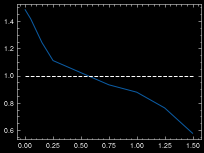

In [41]:
plt.plot(temperatures, fragment_in_smiles)
plt.hlines(1, 0, 1.5, linestyles='dashed')

In [106]:
stats.chisquare([0, 10], [5,5])

Power_divergenceResult(statistic=10.0, pvalue=0.001565402258002549)

In [87]:
test2_smiles[1]['smiles']

{'[H]OC([H])([H])[C@@]1([H])C([H])([H])[C@@]2([H])C([H])([H])C([H])([H])[C@]1([H])C([H])([H])[C@]([H])(O[H])[C@@]([H])(O[H])[C@]2([H])O[H]',
 '[H]OC([H])([H])[C@]1([H])C([H])([H])C([H])([H])[C@@]([H])(c2c([H])c([H])c([H])c([H])c2[H])C([H])([H])C1([H])[H]',
 '[H]c1c([H])c([H])c(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c1[H]',
 '[H]c1c([H])c([H])c(C([H])([H])C([H])([H])C([H])([H])C([H])([H])N2C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c(N([H])C(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c1[H]',
 '[H]c1c([H])c([H])c(C([H])([H])C([H])([H])N2C([H])([H])C([H])([H])C([H])(N([H])C(=O)c3c([H])c([H])c4c(c3[H])C([H])([H])C([H])([H])C([H])([H])N4C(=O)C([H])([H])[H])C([H])([H])C2([H])[H])c([H])c1[H]',
 '[H]c1c([H])c([H])c(C([H])([H])C([H])([H])N2C([H])([H])C([H])([H])N(C([H])([H])C([H])([H])C([H])(

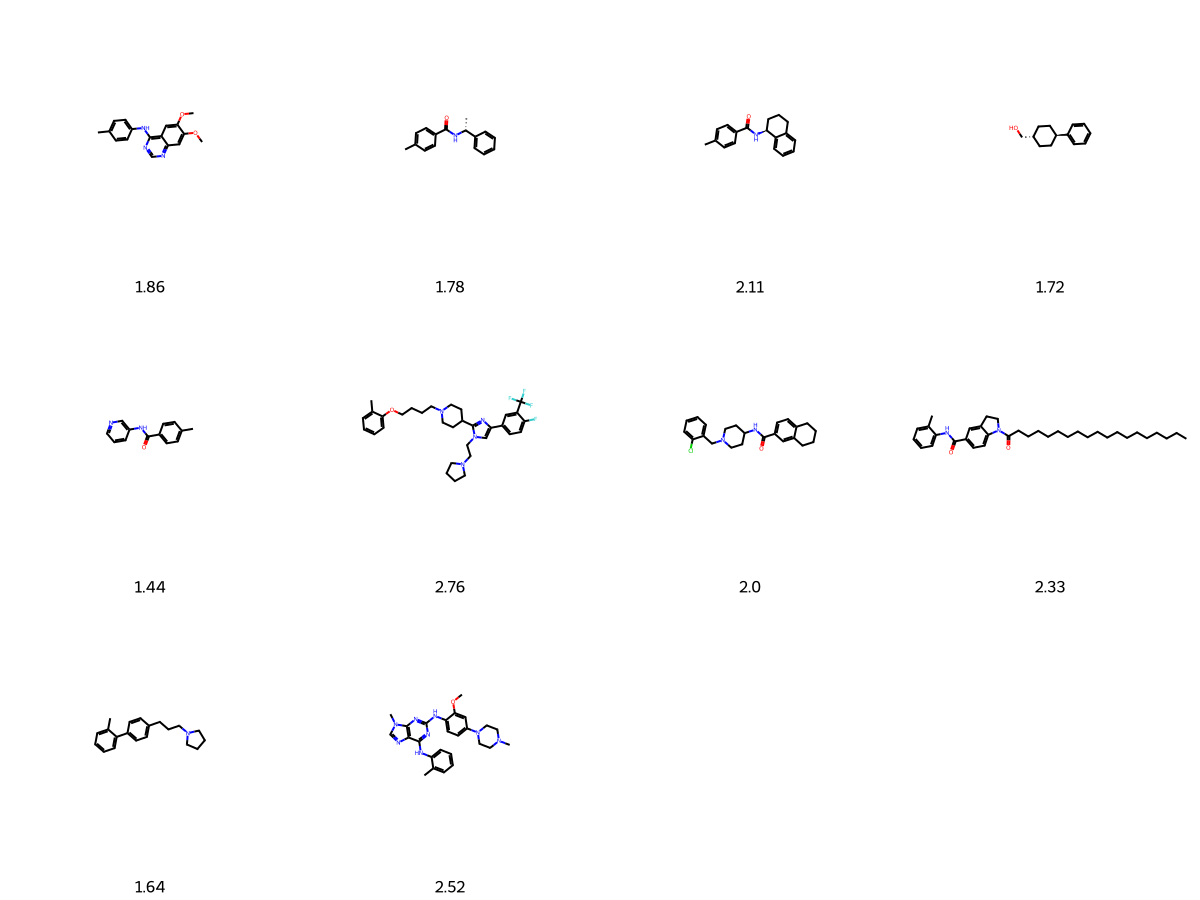

In [85]:
draw_smiles(test2_smiles[1]['smiles'])